In [1]:
# Dependencies
import requests
import json
import pandas as pd
import numpy as np
import gmaps
import matplotlib.pyplot as plt
%matplotlib notebook
from app_token import sf_crime_token
from datetime import date, datetime, timedelta
from config import g_key
gmaps.configure(api_key=g_key)

# API Request
Resource: https://dev.socrata.com/foundry/data.sfgov.org/wg3w-h783

In [2]:
# Base URL
base_url = 'https://data.sfgov.org/resource/wg3w-h783.json'

In [3]:
# Query string parameters
token = f'$$app_token={sf_crime_token}'
order = '$order=incident_datetime ASC'
limit = '$limit=1000000'
lockdown_date = date(2020,3,17)
start_date = lockdown_date-timedelta(days=366)
end_date = lockdown_date+timedelta(days=364)
date_range = f"incident_date between '{start_date}' and '{end_date}'"

In [4]:
# Request URL
request_url = f'{base_url}?{token}&{order}&{limit}&$where={date_range}'

In [5]:
# Store response in DataFrame
data = requests.get(request_url).json()
data_df = pd.DataFrame.from_records(data)

# Data Quality Assessment

### Check Uniqueness

In [6]:
# Determine uniqueness of row_id, incident_id
row_count = len(data_df.index)
row_id_count = data_df['row_id'].nunique()
incident_id_count = data_df['incident_id'].nunique()
print(f'Total Rows: {row_count}')
print(f'Unique Row IDs: {row_id_count}')
print(f'Unique Incident IDs: {incident_id_count}')

Total Rows: 260627
Unique Row IDs: 260627
Unique Incident IDs: 216232


In [7]:
# Determine relationship (i.e., one-to-one or one-to-many) of incident_id and attributes
columns = data_df.columns.values.tolist()
columns.remove('point')
for column in columns:
    attr_row_count = len(data_df[['incident_id', column]].drop_duplicates().index)
    if attr_row_count == incident_id_count:
        relationship = 'one-to-one'
    else:
        relationship = 'one-to-many'
    print(f'{column}: {relationship}')

incident_datetime: one-to-one
incident_date: one-to-one
incident_time: one-to-one
incident_year: one-to-one
incident_day_of_week: one-to-one
report_datetime: one-to-one
row_id: one-to-many
incident_id: one-to-one
incident_number: one-to-one
report_type_code: one-to-one
report_type_description: one-to-one
filed_online: one-to-one
incident_code: one-to-many
incident_category: one-to-many
incident_subcategory: one-to-many
incident_description: one-to-many
resolution: one-to-one
intersection: one-to-one
cnn: one-to-one
police_district: one-to-one
analysis_neighborhood: one-to-one
supervisor_district: one-to-one
latitude: one-to-one
longitude: one-to-one
cad_number: one-to-one


**Finding:** *Row_id* is a unique identifier for each record, while *incident_id* is not. An *incident_id* may appear in multiple records when the incident involves two or more offenses, e.g., illegal possession of drugs and speeding. The following fields are responsible for the duplications: *incident_code*, *incident_category*, *incident_subcategory*, and *incident_description*. All other incident attributes take on a maximum of one value per *incident_id*.

### Check Completeness

In [8]:
# Calculate percentage of non-missing values per column
data_df.count() / row_count

incident_datetime          1.000000
incident_date              1.000000
incident_time              1.000000
incident_year              1.000000
incident_day_of_week       1.000000
report_datetime            1.000000
row_id                     1.000000
incident_id                1.000000
incident_number            1.000000
report_type_code           1.000000
report_type_description    1.000000
filed_online               0.189562
incident_code              1.000000
incident_category          0.998715
incident_subcategory       0.998715
incident_description       1.000000
resolution                 1.000000
intersection               0.950186
cnn                        0.950186
police_district            1.000000
analysis_neighborhood      0.950186
supervisor_district        0.950186
latitude                   0.950186
longitude                  0.950186
point                      0.950186
cad_number                 0.789404
dtype: float64

**Finding:** The dataset is sufficiently comprehensive because it captures key incident details such as date, time, category, and location. Furthermore, the frequency of missing values did not exceed 5% for any significant column. Additional details about the perpetrator and victim would have been interesting.

### Check Timeliness

In [9]:
# Calculate elapsed time from incident to recording of incident
# Resource: https://www.datasciencemadesimple.com/difference-two-timestamps-seconds-minutes-hours-pandas-python-2/
time_df = data_df[['incident_id', 'report_datetime', 'incident_datetime']].drop_duplicates()
time_df[['report_datetime', 'incident_datetime']] = time_df[['report_datetime', 'incident_datetime']].apply(pd.to_datetime)
time_df['diff_datetime'] = time_df['report_datetime'] - time_df['incident_datetime']
time_df['diff_hours'] = time_df['diff_datetime'] / np.timedelta64(1,'h')

In [10]:
# Calculate distribution of elapsed time
quantiles = np.arange(0.05, 1, 0.05)
for item in quantiles:
    value = time_df['diff_hours'].quantile(item)
    print(f"Quantile {'{:.2f}'.format(item)}: {'{:.2f}'.format(value)} Hours")

Quantile 0.05: 0.00 Hours
Quantile 0.10: 0.00 Hours
Quantile 0.15: 0.00 Hours
Quantile 0.20: 0.05 Hours
Quantile 0.25: 0.12 Hours
Quantile 0.30: 0.23 Hours
Quantile 0.35: 0.50 Hours
Quantile 0.40: 1.12 Hours
Quantile 0.45: 2.05 Hours
Quantile 0.50: 3.45 Hours
Quantile 0.55: 6.23 Hours
Quantile 0.60: 11.20 Hours
Quantile 0.65: 15.67 Hours
Quantile 0.70: 21.13 Hours
Quantile 0.75: 31.10 Hours
Quantile 0.80: 51.90 Hours
Quantile 0.85: 93.70 Hours
Quantile 0.90: 187.87 Hours
Quantile 0.95: 542.12 Hours


**Finding:** Incident reports are filed in a timely manner. The median elapsed time from incident occurrence to report filing is a mere 3 hours and 26 minutes. Q<sub>1</sub> = 7 minutes and Q<sub>3</sub> = 30 hours and 40 minutes. Once filed, incident reports are published via an automated daily update.

### Check Consistency

In [11]:
# Count incident_category labels
# Resource: https://towardsdatascience.com/master-the-most-hated-task-in-ds-ml-3b9779276d7c
incident_categories = data_df['incident_category'].value_counts().sort_index()
print(incident_categories)

Arson                                           785
Assault                                       15611
Burglary                                      16144
Case Closure                                   1094
Civil Sidewalks                                 248
Courtesy Report                                 768
Disorderly Conduct                             4433
Drug Offense                                   6063
Drug Violation                                   87
Embezzlement                                    350
Fire Report                                     364
Forgery And Counterfeiting                      930
Fraud                                          7954
Gambling                                          5
Homicide                                         29
Human Trafficking (A), Commercial Sex Acts       24
Human Trafficking, Commercial Sex Acts           13
Larceny Theft                                 76121
Liquor Laws                                      15
Lost Propert

In [12]:
# Count police_district labels
police_districts = data_df['police_district'].value_counts().sort_index()
print(police_districts)

Bayview       23878
Central       36006
Ingleside     20713
Mission       32494
Northern      37083
Out of SF      7585
Park          12896
Richmond      16957
Southern      30310
Taraval       18316
Tenderloin    24389
Name: police_district, dtype: int64


In [13]:
# Count analysis_neighborhood labels
neighborhoods = data_df['analysis_neighborhood'].value_counts().sort_index()
print(neighborhoods)

Bayview Hunters Point             16505
Bernal Heights                     4838
Castro/Upper Market                7690
Chinatown                          4492
Excelsior                          4461
Financial District/South Beach    19230
Glen Park                          1464
Golden Gate Park                   2533
Haight Ashbury                     4267
Hayes Valley                       7326
Inner Richmond                     3393
Inner Sunset                       3304
Japantown                          2337
Lakeshore                          2914
Lincoln Park                        406
Lone Mountain/USF                  3219
Marina                             7399
McLaren Park                        317
Mission                           25945
Mission Bay                        4514
Nob Hill                           7523
Noe Valley                         2842
North Beach                        6714
Oceanview/Merced/Ingleside         2547
Outer Mission                      3753


**Finding:** In *incident_category*, multiple inconsistencies exists: the word "Offense" is sometimes spelled "Offence", a "?" is appended to "Motor Vehicle Theft", and "(A)" is inserted into "Human Trafficking, Commercial Sex Acts." Furthermore, the field requires grouping of several categories: "Drug Violation" into "Drug Offense", "Other" and "Other Offenses" into "Other Miscellaneous", "Suspicious" into "Suspicious Occ", and "Weapons Carrying Etc" into "Weapons Offense". In *analysis_neighborhood*, an inconsistency exists across "null" and blank values; they are two representations of the same value.

# Data Cleansing

In [14]:
# Fill missing and psuedo-missing values
data_df.fillna({'analysis_neighborhood':'Not Disclosed', 'incident_category':'Not Disclosed'}, inplace=True)
data_df['analysis_neighborhood'].replace('null','Not Disclosed', inplace=True)

In [15]:
# Fix inconsistencies
data_df['incident_category'].replace(['Offence','\?',' \(A\)'],['Offense','',''], inplace=True, regex=True)

In [16]:
# Group similar categories
originals = ['Drug Violation','Other','Other Offenses','Suspicious','Weapons Carrying Etc']
replacements = ['Drug Offense','Other Miscellaneous','Other Miscellaneous','Suspicious Occ', 'Weapons Offense']
data_df['incident_category'].replace(originals, replacements, inplace=True)

In [17]:
# Slice df so incidents prior to and following the lockdown are separated
pre_df = data_df.loc[data_df['incident_date'] < lockdown_date.strftime('%Y-%m-%d')]
post_df = data_df.loc[data_df['incident_date'] >= lockdown_date.strftime('%Y-%m-%d')]

In [18]:
# Export df to csv
data_df.to_csv('data.csv', header=True, index=False)
pre_df.to_csv('pre_data.csv', header=True, index=False)
post_df.to_csv('post_data.csv', header=True, index=False)

# Data Analysis

### Daily Incidents

In [19]:
# Count incidents reported each day (overall, pre/post lockdown, 30 days pre/post lockdown)
daily_ser = data_df.groupby('incident_date')['incident_id'].nunique()
daily_ser.index = pd.to_datetime(daily_ser.index).date
daily_pre_ser = daily_ser.loc[daily_ser.index < lockdown_date]
daily_post_ser = daily_ser.loc[daily_ser.index >= lockdown_date]
daily_60_pre_ser = daily_ser.loc[(daily_ser.index >= lockdown_date - timedelta(days=60)) & (daily_ser.index < lockdown_date)]
daily_60_post_ser = daily_ser.loc[(daily_ser.index >= lockdown_date) & (daily_ser.index < lockdown_date + timedelta(days=60))]

In [20]:
# Calculate daily averages
avg_inc = daily_ser.mean()
avg_inc_pre = daily_pre_ser.mean()
avg_inc_post = daily_post_ser.mean()
avg_inc_60_pre = daily_60_pre_ser.mean()
avg_inc_60_post = daily_60_post_ser.mean()

In [21]:
# Print averages
print(f'Mean: {avg_inc}')
print(f'Mean, 1 Year Pre-Lockdown: {avg_inc_pre}')
print(f'Mean, 1 Year Post-Lockdown: {avg_inc_post}')
print(f'Mean, 60 Days Pre-Lockdown: {avg_inc_60_pre}')
print(f'Mean, 60 Days Post-Lockdown: {avg_inc_60_post}')

Mean: 295.8030095759234
Mean, 1 Year Pre-Lockdown: 337.051912568306
Mean, 1 Year Post-Lockdown: 254.44109589041096
Mean, 60 Days Pre-Lockdown: 317.98333333333335
Mean, 60 Days Post-Lockdown: 217.58333333333334


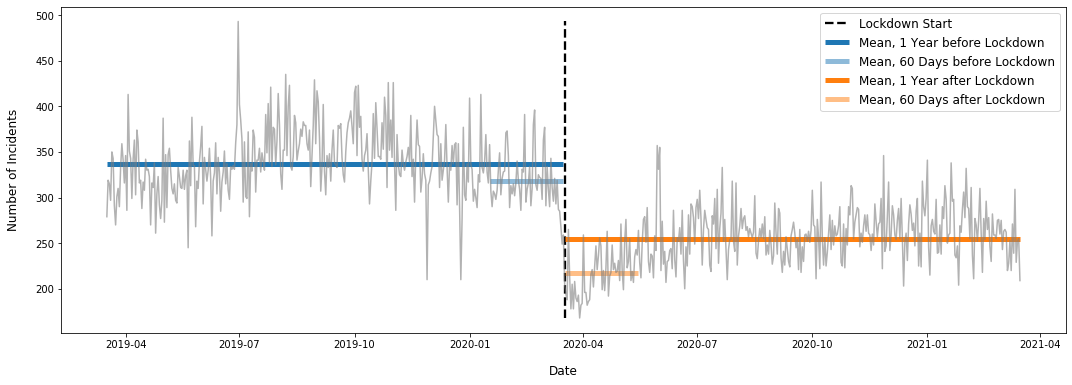

In [22]:
# Plot
# Resource: https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html
pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(18,6))
plt.plot(daily_ser.index, daily_ser, color='C7', alpha=0.6)
plt.vlines(lockdown_date, daily_ser.min(), daily_ser.max(), color='black', linestyles='--', linewidth=2.3, label='Lockdown Start')
plt.hlines(avg_inc_pre, daily_pre_ser.index.min(), daily_pre_ser.index.max(), color='C0', linewidth=5, label='Mean, 1 Year before Lockdown')
plt.hlines(avg_inc_60_pre, daily_60_pre_ser.index.min(), daily_60_pre_ser.index.max(), color='C0', linewidth=5, alpha=0.5, label='Mean, 60 Days before Lockdown')
plt.hlines(avg_inc_post, daily_post_ser.index.min(), daily_post_ser.index.max(), color='C1', linewidth=5, label='Mean, 1 Year after Lockdown')
plt.hlines(avg_inc_60_post, daily_60_post_ser.index.min(), daily_60_post_ser.index.max(), color='C1', linewidth=5, alpha=0.5, label='Mean, 60 Days after Lockdown')
plt.xlabel('Date', fontsize=12, labelpad=15)
plt.ylabel('Number of Incidents', fontsize=12, labelpad=15)
plt.legend(fontsize=12)
plt.savefig('img/incidents_daily.png')

### Police District Incidents

In [32]:
# Count incidents reported to each police district
district_pre_ser = pre_df.groupby('police_district')['incident_id'].nunique().rename('inc_pre')
district_post_ser = post_df.groupby('police_district')['incident_id'].nunique().rename('inc_post')
district_df = pd.concat([district_pre_ser, district_post_ser], axis=1)

In [33]:
# Calculate difference and percent difference
district_df['inc_diff'] = district_df['inc_post'] - district_df['inc_pre']
district_df['inc_diff_perc'] = district_df['inc_diff'] / district_df['inc_pre'] * 100
#district_df.sort_values('inc_pre', ascending=False, inplace=True)
district_df

,inc_pre,inc_post,inc_diff,inc_diff_perc
police_district,,,,
Bayview,10091,9804,-287,-2.844119
Central,19120,10594,-8526,-44.592050
Ingleside,8672,8691,19,0.219096
Mission,15424,10791,-4633,-30.037604
Northern,18196,13302,-4894,-26.896021
Out of SF,3467,3014,-453,-13.066051
Park,5927,5175,-752,-12.687700
Richmond,8354,6762,-1592,-19.056739
Southern,14758,10068,-4690,-31.779374


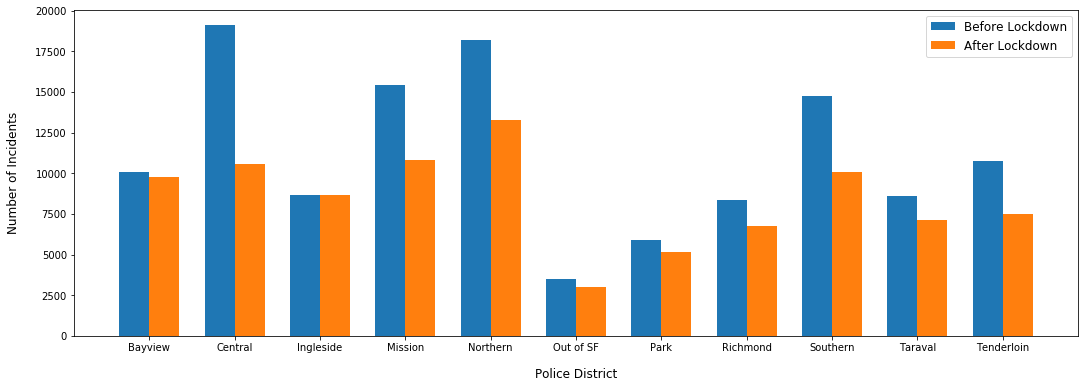

In [34]:
# Plot
labels = district_df.index
x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(18,6))
rects1 = plt.bar(x - width/2, district_df['inc_pre'], width, color='C0', label='Before Lockdown')
rects2 = plt.bar(x + width/2, district_df['inc_post'], width, color='C1', label='After Lockdown')
plt.xticks(x, labels)
plt.xlabel('Police District', fontsize=12, labelpad=15)
plt.ylabel('Number of Incidents', fontsize=12, labelpad=15)
plt.legend(fontsize=12)
plt.savefig('img/incidents_police_district.png')

### Category Incidents

In [35]:
# Count incidents by 'incident_category'
cat_pre_ser = pre_df.groupby('incident_category')['incident_id'].nunique().rename('inc_pre')
cat_post_ser = post_df.groupby('incident_category')['incident_id'].nunique().rename('inc_post')
cat_df = pd.concat([cat_pre_ser, cat_post_ser], sort=True, axis=1).fillna(0)
cat_df['inc_post'] = cat_df['inc_post'].astype(int)
cat_df.sort_values(by=['inc_post'], ascending=True, inplace=True)
cat_df.drop(labels='Not Disclosed', axis=0, inplace=True)

In [36]:
# Calculate percent difference, determine bar color (i.e., green or red for positive or negative)
cat_df['inc_diff_perc'] = (cat_df['inc_post'] - cat_df['inc_pre']) / cat_df['inc_pre'] * 100
cat_df['color'] = ['C3' if perc < 0 else 'C2' for perc in cat_df['inc_diff_perc']]

In [37]:
# Shorten 'incident_category' labels for improved chart readability
cat_df.rename(index={'Human Trafficking, Commercial Sex Acts': 'Human Trafficking',
                    'Offenses Against The Family And Children': 'Offenses Against The Family'}, inplace=True)

In [38]:
# Append post-lockdown incident count to index
cat_df.index = cat_df.index + ' (' + cat_df['inc_post'].astype(str) + ')'

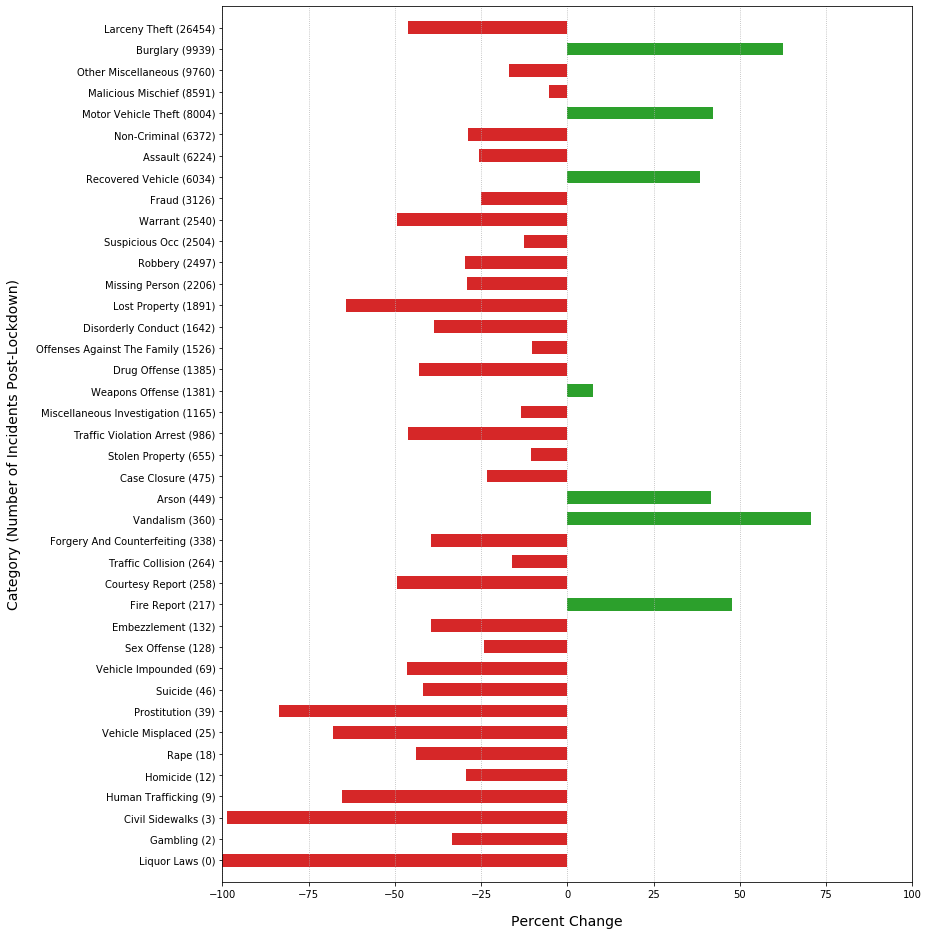

In [60]:
# Plot
plt.figure(figsize=(13, 13.1))
plt.barh(cat_df.index, cat_df['inc_diff_perc'], height=0.6, color=cat_df['color'])
plt.xlabel('Percent Change', fontsize=14, labelpad=15)
plt.ylabel('Category (Number of Incidents Post-Lockdown)', fontsize=14, labelpad=15)
plt.xlim(-100, max(100, cat_df['inc_diff_perc'].max()))
plt.ylim(-1, len(cat_df.index))
plt.grid(axis='x', linestyle=':')
plt.tight_layout()
plt.savefig('img/incidents_category.png')

### Map Incidents

In [56]:
# Determine a set of 'incident_category' labels on which to focus
inc_cats = ['Burglary', 'Motor Vehicle Theft']
cat_pre_df = pre_df.loc[data_df['incident_category'].isin(inc_cats)]
cat_post_df = post_df.loc[data_df['incident_category'].isin(inc_cats)]

In [57]:
# Create function that maps incidents by latitude and longitude
# Resource: https://jupyter-gmaps.readthedocs.io/en/latest/tutorial.html
def map_incidents(df):
    latlong_df = df[['incident_id', 'latitude', 'longitude']].copy().drop_duplicates().dropna(how='any')
    locations = latlong_df[['latitude', 'longitude']].astype(float)
    fig_layout_dict = {'width':'1000px', 'height':'1000px', 'border':'1px solid black', 'padding':'5px'}
    fig = gmaps.figure(layout=fig_layout_dict)
    heat_layer = gmaps.heatmap_layer(locations, dissipating=True, max_intensity=6, point_radius=6)
    fig.add_layer(heat_layer)
    return fig

In [58]:
# Map pre-lockdown incidents
map_incidents(cat_pre_df)

Figure(layout=FigureLayout(border='1px solid black', height='1000px', padding='5px', width='1000px'))

In [59]:
# Map post-lockdown incidents
map_incidents(cat_post_df)

Figure(layout=FigureLayout(border='1px solid black', height='1000px', padding='5px', width='1000px'))

### Neighborhood Incidents

In [ ]:
# Create function that charts incidents by neighborhood
def chart_neighborhood_incidents(df, timing):
    district_ser = df.groupby('analysis_neighborhood')['incident_id'].nunique()
    district_ser.sort_values(ascending=True, inplace=True)
    plt.figure(figsize=(10,10))
    plt.barh(district_ser.index, district_ser, height=0.5, color='C0', align='center')
    plt.title(f'Neighborhood Incidents {timing}-Lockdown')
    plt.xlabel('NUmber of Incidents')
    plt.ylabel('Neighborhood')
    plt.ylim(-0.5, len(district_ser)-0.5)
    plt.tick_params(axis='y',left=False)
    plt.tight_layout()
    plt.savefig(f'img/incidents_neighborhood_{timing.lower()}.png')

In [ ]:
# Map pre-lockdown incidents
chart_neighborhood_incidents(cat_pre_df, 'Pre')

In [ ]:
# Map pre-lockdown incidents
chart_neighborhood_incidents(cat_post_df, 'Post')

## Data Analysis

**Category Analysis**

In [ ]:
# Group total incidents by category
pre_cat_ser = pre_df.groupby('incident_category')['incident_id'].nunique().rename('pre_incidents')
post_cat_ser = post_df.groupby('incident_category')['incident_id'].nunique().rename('post_incidents')

In [ ]:
# Concatenate pre and post incidents, calculate percent change
cat_df = pd.concat([pre_cat_ser, post_cat_ser], sort=True, axis=1).fillna(0)
cat_df['post_incidents'] = cat_df['post_incidents'].astype(int)
cat_df.drop(labels='Not Disclosed', axis=0, inplace=True)
cat_df['percent_change'] = (cat_df['post_incidents'] - cat_df['pre_incidents']) / cat_df['pre_incidents'] * 100
cat_df.sort_values(by=['post_incidents'], ascending=True, inplace=True)
cat_df.index = cat_df.index + ' (' + cat_df['post_incidents'].astype(str) + ')'

In [ ]:
# Plot
plt.figure(figsize=(10,10))
plt.barh(cat_df.index, cat_df['percent_change'], height=0.5, color='royalblue', align='center')
plt.title(f'Category Incidents Post-Lockdown')
plt.xlabel('Percent Change YOY')
plt.ylabel('Category (Incidents)')
plt.xlim(-100, max(100, cat_df['percent_change'].max()))
plt.ylim(-0.5, len(cat_df.index)-0.5)
plt.tick_params(axis='y',left=False)
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('img/incidents_category.png')

**Narrow Scope to Crimes of Stolen Property Only**

In [ ]:
stolen_types = ['Burglary', 'Larceny Theft', 'Lost Property', 'Motor Vehicle Theft', 'Robbery', 'Stolen Property']
stolen_pre_df = pre_df.loc[data_df['incident_category'].isin(stolen_types)]
stolen_post_df = post_df.loc[data_df['incident_category'].isin(stolen_types)]

**Map Analysis**<br>
Resource: https://jupyter-gmaps.readthedocs.io/en/latest/tutorial.html

In [ ]:
# Map incidents by latitude and longitude
def map_incidents(df):
    latlong_df = df[['incident_id', 'latitude', 'longitude']].copy().drop_duplicates().dropna(how='any')
    locations = latlong_df[['latitude', 'longitude']].astype(float)
    fig_layout_dict = {'width':'1000px', 'height':'1000px', 'border':'1px solid black', 'padding':'5px'}
    fig = gmaps.figure(layout=fig_layout_dict)
    heat_layer = gmaps.heatmap_layer(locations, dissipating=True, max_intensity=5, point_radius=5)
    fig.add_layer(heat_layer)
    return fig

In [ ]:
# Map pre-lockdown incidents
map_incidents(stolen_pre_df)

In [ ]:
# Map post-lockdown incidents
map_incidents(stolen_post_df)

**Neighborhood Analysis**

In [ ]:
# Group incidents by neighborhood
def chart_neighborhood_incidents(df, timing):
    district_ser = df.groupby('analysis_neighborhood')['incident_id'].nunique()
    district_ser.sort_values(ascending=True, inplace=True)
    plt.figure(figsize=(10,10))
    plt.barh(district_ser.index, district_ser, height=0.5, color='royalblue', align='center')
    plt.title(f'Neighborhood Incidents {timing}-Lockdown')
    plt.xlabel('Incidents')
    plt.ylabel('Neighborhood')
    plt.ylim(-0.5, len(district_ser)-0.5)
    plt.tick_params(axis='y',left=False)
    plt.tight_layout()
    plt.savefig(f'img/incidents_neighborhood_{timing.lower()}.png')

In [ ]:
# Chart pre-lockdown incidents
chart_neighborhood_incidents(stolen_pre_df, 'Pre')

In [ ]:
# Chart post-lockdown incidents
chart_neighborhood_incidents(stolen_post_df, 'Post')

**Time Analysis**

In [ ]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [ ]:
# Group total incidents by day and hour
def chart_time_incidents(start_date, end_date, df, timing):
    
    # Count occurrence of each day of week within date range
    # Resource: https://numpy.org/doc/stable/reference/generated/numpy.busday_count.html
    days_dict = {}
    def day_counter(start_date, end_date, day):
        day_count = np.busday_count(start_date, end_date+timedelta(days=1), weekmask=day)
        return day_count
    for day in days:
        days_dict[day] = day_counter(start_date, end_date, day)
    
    # Group total incidents by day and hour
    # Resource: https://www.javaer101.com/en/article/17171715.html
    time_df = df[['incident_day_of_week', 'incident_time', 'incident_id']].copy().drop_duplicates()
    day_cats = pd.api.types.CategoricalDtype(categories=days, ordered=True)
    time_df['day_abbr'] = time_df['incident_day_of_week'].str[:3].astype(day_cats)
    time_df['incident_hour'] = time_df['incident_time'].str[:2].astype(int)
    time_ser = time_df.groupby(['day_abbr', 'incident_hour'])['incident_id'].nunique().astype(float)
    
    # Convert total incidents to average incidents by weekday and hour
    def day_count_divisor(day):
        time_ser[day] = time_ser.loc[day].divide(days_dict[day], level='day_abbr')
    for day in days:
        day_count_divisor(day)

    # Plot
    time_ser.unstack(level=0).plot(
        kind='line',
        figsize=(12,8),
        title=f'Average Hourly Incidents {timing}-Lockdown')
    plt.xlabel('Hour')
    plt.ylabel('Average Incidents')
    plt.ylim(0, time_ser.max()*1.2)
    plt.xticks(np.arange(0,24,2))
    plt.legend(title='Day of Week')
    plt.tight_layout()
    plt.savefig(f'img/incidents_hourly_{timing.lower()}.png')

In [ ]:
chart_time_incidents(start_date, lockdown_date-timedelta(days=1), stolen_pre_df, 'Pre')

In [ ]:
chart_time_incidents(lockdown_date, end_date, stolen_post_df, 'Post')